Author: Daniel Low

Based on tutorials:
- https://github.com/huggingface/notebooks/blob/e1983033bf88432e1e371996e1deec2f6ef1c52a/examples/text_classification.ipynb
- https://huggingface.co/blog/ray-tune
- https://huggingface.co/docs/transformers/training

In [4]:
# python and package Versions used

!python --version # I ran on python==3.10.12

Python 3.10.12


In [5]:
!pip install -q torch==2.0.1 datasets==2.14.3 transformers==4.28.1 accelerate==0.15.0 optuna==3.2.0 imbalanced-learn==0.11.0



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━

In [6]:
import torch

torch.cuda.is_available()

True

In [7]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = True



if on_colab:
  from google.colab import drive
  project_name = 'rallypoint_suicide_detection'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/final_datasets/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/input/final_datasets/'
  output_dir = './data/output/'

os.makedirs(output_dir, exist_ok=True)


Mounted at /content/drive


In [13]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from datasets import load_dataset, load_metric
from datasets import list_metrics
from imblearn.over_sampling import RandomOverSampler


# Fine-tuning a model on a text classification task

In [56]:
toy = False
task = "stb"
model_checkpoint = "roberta-base" # "distilbert-base-uncased"
num_labels = 2 # Use 1 for regression
metric_name = "f1"
validation_key = 'validation'
imbalanced = False # if True, will use custom function. False = leave imabalance or balance through oversampling/undersampling/etc

### training or hyperparameter search arguments

In [15]:

# if finetuning without hypeparameter search
batch_size = 16 #not higher due to GPU memory usage limit issues
if toy:
    epochs = 1
else:
    epochs = 3


# hyperparameter search args
do_hyperparameter_search = True
hyperparameter_shards = 5 # 10 means you use 10th of the data from hyperparameter search
hyperparameter_search_n_trials = 10
hyperparameter_search_direction = 'maximize'

In [16]:
# if searching with hyperparameter search, options are default of optuna or specified here:


# default optuna decided by transformers: https://github.com/huggingface/transformers/blob/dcbfd93d7aeb14f8ff08a48866d2a68950d4c69a/src/transformers/trainer_utils.py#L248

# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1,4, step=1),
        "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    }


## Loading the dataset

In [18]:
print(X_train.shape, y_train.shape)

(6478,) (6478,)


In [42]:
train = pd.read_csv(input_dir+'train.csv', index_col=0)
val = pd.read_csv(input_dir+'val.csv', index_col=0)
test = pd.read_csv(input_dir+'test.csv', index_col=0)
print(train.shape, test.shape)

if toy:
  train = pd.read_csv(input_dir+'train.csv', index_col=0).sample(frac = 0.1)
  val = pd.read_csv(input_dir+'val.csv', index_col=0).sample(frac = 0.1)
  test = pd.read_csv(input_dir+'test.csv', index_col=0).sample(frac = 0.1)


X_train = train['content'].values
# X_train_metadata = train[['type_tag_content','contact_size','reputation','type']]
y_train = train['label'].astype(int).values
# y_train = Tensor(y_train).to(torch.int64)
# y_train = one_hot(y_train, num_classes=2)

X_val = val['content'].values
y_val = val['label'].astype(int).values

X_test = test['content'].values
y_test = test['label'].astype(int).values

# Oversample to match method of model with metadata approach
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train.reshape(-1, 1), y_train)
X_train = X_train.flatten()

d = {'train':Dataset.from_dict({'label':y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':y_test,'text':X_test})
     }




dataset = DatasetDict(d)


(6478, 10) (1279, 11)


In [45]:
dataset['train']['label'][:10]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [46]:

metrics_list = list_metrics()
print(len(metrics_list))
print(metrics_list)
metric = load_metric("f1")
metric

132
['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'cuad', 'exact_match', 'f1', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'He-Xingwei/sari_metric', 'Ikala-allen/relation_extraction', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', 'Muennighoff/code_eval_octopack', 'NCSOFT/harim_plus', 'Natooz/ece', 'NikitaMartynov/spell-chec

Metric(name: "f1", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel targets. If set to `None`, the sco

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [47]:


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [48]:
# show_random_elements(dataset["train"], num_examples=3)

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [49]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'f1': 0.5671641791044777}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

(…)co/roberta-base/resolve/main/config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [26]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [0, 31414, 6, 42, 65, 3645, 328, 2, 2, 2409, 42, 3645, 1411, 19, 24, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [27]:
task = 'stb'

task_to_keys = {
    'stb': ("text", None),
}

We can double check it does work on our current dataset:

In [50]:
sentence1_key, sentence2_key = task_to_keys[task]



if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: That's kinda where I thought it would be, had not seen those posts


In [51]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [53]:
sentence1_key, sentence2_key = task_to_keys[task]

preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 1711, 18, 24282, 147, 38, 802, 24, 74, 28, 6, 56, 45, 450, 167, 4570, 2], [0, 100, 524, 5, 704, 9, 127, 12, 826, 13, 522, 6359, 35, 3296, 42743, 73, 29774, 10887, 73, 510, 2685, 495, 131, 15, 622, 4, 1437, 404, 522, 6359, 6, 522, 43290, 4189, 6, 8, 522, 2732, 32, 3279, 352, 2814, 7, 1962, 127, 333, 4, 2], [0, 100, 10745, 358, 363, 13, 1840, 7, 253, 127, 3606, 6, 53, 2085, 38, 33, 7, 253, 24, 2185, 4, 2], [0, 12350, 2949, 4, 370, 73, 1694, 32, 5, 1980, 54, 32, 430, 4, 36698, 32, 667, 7, 1346, 12, 463, 40455, 3842, 12846, 1599, 75, 492, 62, 15, 106, 6, 8, 51, 351, 75, 492, 62, 15, 47, 4, 2315, 103, 244, 12, 11970, 40455, 7, 244, 47, 4, 178, 608, 24, 1937, 129, 817, 24, 4851, 4, 2], [0, 1711, 18, 99, 38, 21, 2053, 4, 38, 399, 75, 190, 146, 24, 149, 5, 1786, 9, 5, 527, 4, 370, 393, 28930, 22, 2362, 113, 11, 10, 7337, 1155, 142, 24, 4428, 95, 101, 22, 2977, 845, 39895, 18, 32, 6523, 7, 5, 1933, 98, 4, 1993, 39895, 18, 218, 75, 283, 31, 5217, 2833, 6, 51, 283, 31, 5, 9755,

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [54]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/11682 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model with or without hyperparameter search

In [57]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, classification_report
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

def metrics_report_cm(y_true, y_pred, output_dir, model_name, ts, save=True):

    cm = confusion_matrix(y_true, y_pred,normalize=None)
    cm_df = pd.DataFrame(cm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])
    cm_df_meaning = pd.DataFrame([['TN', 'FP'],['FN','TP']], index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])

    cm_norm = confusion_matrix(y_true, y_pred,normalize='all')
    cm_norm = (cm_norm*100).round(2)
    cm_df_norm = pd.DataFrame(cm_norm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])


    plt.rcParams['figure.figsize'] = [4,4]
    cm_display = ConfusionMatrixDisplay(cm_norm,display_labels=['SITB-', 'SITB+']).plot()
    # todo save

    if save:
        cm_df_meaning.to_csv(output_dir+f'cm_meaning_{model_name}_{ts}.csv')
        cm_df.to_csv(output_dir+f'cm_{model_name}_{ts}.csv')
        cm_df_norm.to_csv(output_dir+f'cm_norm_{model_name}_{ts}.csv')



    return cm_df_meaning, cm_df, cm_df_norm




def metrics_report_classification_report(y_true, y_pred,y_pred_proba_1, output_dir, model_name, ts):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    np.set_printoptions(suppress=True)
    roc_auc = roc_auc_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)

    # calculate precision and recall for each threshold
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_true, y_pred_proba_1)

    # TODO: add best threshold
    fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
    fscore[np.isnan(fscore)] = 0
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix].item()


    pr_auc = auc(lr_recall, lr_precision)
    # AU P-R curve is also approximated by avg. precision
    # avg_pr = metrics.average_precision_score(y_true,y_pred_proba_1)

    sensitivity = recall_score(y_true,y_pred)
    specificity = tn / (tn+fp) # OR: recall_score(y_true,y_pred, pos_label=0)
    precision = precision_score(y_true,y_pred)

    results = pd.DataFrame([sensitivity, specificity,precision,f1, roc_auc,pr_auc, best_threshold],
                        index = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'ROC AUC','PR AUC', 'Best th PR AUC']).T.round(2)

    results.to_csv(output_dir+f'results_{model_name}_{ts}.csv')
    return results




Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

### Custom Trainer to add class weights if you have class imbalance

In [58]:

from torch import nn
from transformers import Trainer

from sklearn.utils.class_weight import compute_class_weight

class_weights =  compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
print(class_weights)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

[1. 1.]


### define or download model and define training arguments

In [59]:
%%time

# Finetuning no hyperparameter search:
# distilroberta 18m (4 epochs)
# roberta-base 35m (3 epochs)



model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,

  push_to_hub=False,

)

if do_hyperparameter_search:
    model = None
    def create_model_init():
        return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    model_init = create_model_init


else:
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    model_init=None


def define_trainer(encoded_train_set, encoded_val_set, model=None, model_init=None, compute_metrics = None, imbalanced = imbalanced):
    if not imbalanced:
        trainer = Trainer(
            model = model,
            model_init = model_init,
            args = args,
            train_dataset=encoded_train_set,
            eval_dataset=encoded_val_set,
            tokenizer=tokenizer,
          compute_metrics=compute_metrics,
        )

    else:
        # here we use a CustomTrainer for class weights
        trainer = CustomTrainer(
            model = model,
            model_init = model_init,
            args = args,
            train_dataset=encoded_train_set,
            eval_dataset=encoded_val_set,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
    return trainer



CPU times: user 5.12 ms, sys: 6.01 ms, total: 11.1 ms
Wall time: 16.3 ms


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

# Train and save model

In [60]:
%%time

encoded_train_set = encoded_dataset["train"]
encoded_val_set = encoded_dataset[validation_key]

if do_hyperparameter_search:
    if hyperparameter_shards:
        encoded_train_dataset_shards = encoded_train_set.shard(index=1, num_shards=hyperparameter_shards)
        trainer = define_trainer(encoded_train_dataset_shards, encoded_val_set, model=model, model_init=model_init , compute_metrics = compute_metrics,imbalanced=imbalanced)

    best_run = trainer.hyperparameter_search(n_trials=hyperparameter_search_n_trials,
                                             direction=hyperparameter_search_direction,
                                             backend='optuna',
                                             hp_space = optuna_hp_space, # or will use default hp_space for whatever the backend is
                                             )
    print('==== best run:', best_run)
    print()

    # re define the trainer with the entire dataset
    trainer = define_trainer(encoded_train_set, encoded_val_set, model=model, model_init=model_init , compute_metrics = compute_metrics, imbalanced=imbalanced)
    for n, v in best_run.hyperparameters.items():
        setattr(trainer.args, n, v)

# train on entire training set for the last time
trainer.train()

ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir_i = output_dir+model_checkpoint+f'_{ts}/'
os.makedirs(output_dir_i , exist_ok=True)
trainer.save_model(output_dir_i)
# trainer.push_to_hub() # need to have added token above in TrainingArguments()

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,F1
1,No log,0.262396,0.542169
2,No log,0.289438,0.583333


[I 2023-11-06 03:42:54,243] Trial 0 finished with value: 0.5833333333333334 and parameters: {'learning_rate': 7.789401047161447e-06, 'num_train_epochs': 2, 'weight_decay': 3.585920286427533e-07}. Best is trial 0 with value: 0.5833333333333334.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

Epoch,Training Loss,Validation Loss,F1
1,No log,0.324819,0.569832
2,No log,0.324238,0.644737


[I 2023-11-06 03:49:55,969] Trial 1 finished with value: 0.6447368421052632 and parameters: {'learning_rate': 5.9357284796448314e-05, 'num_train_epochs': 2, 'weight_decay': 5.098222775575285e-10}. Best is trial 1 with value: 0.6447368421052632.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequen

Epoch,Training Loss,Validation Loss,F1
1,No log,0.413405,0.533333
2,No log,0.415991,0.608187
3,No log,0.338258,0.671756
4,0.187200,0.378745,0.705036


[I 2023-11-06 04:03:47,126] Trial 2 finished with value: 0.7050359712230215 and parameters: {'learning_rate': 4.053977695563393e-05, 'num_train_epochs': 4, 'weight_decay': 7.863428878141934e-10}. Best is trial 2 with value: 0.7050359712230215.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

Epoch,Training Loss,Validation Loss,F1
1,No log,0.493261,0.371542


[I 2023-11-06 04:07:16,001] Trial 3 finished with value: 0.3715415019762846 and parameters: {'learning_rate': 6.919588559902211e-06, 'num_train_epochs': 1, 'weight_decay': 0.00012216850011952882}. Best is trial 2 with value: 0.7050359712230215.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequen

Epoch,Training Loss,Validation Loss,F1
1,No log,0.709140,0.186851
2,No log,0.482496,0.392453
3,No log,0.348363,0.459330
4,0.487500,0.334147,0.460000


[I 2023-11-06 04:21:12,906] Trial 4 finished with value: 0.46 and parameters: {'learning_rate': 2.3107957678576628e-06, 'num_train_epochs': 4, 'weight_decay': 2.346827555822773e-07}. Best is trial 2 with value: 0.7050359712230215.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificati

Epoch,Training Loss,Validation Loss,F1
1,No log,0.472830,0.463636


[I 2023-11-06 04:24:35,478] Trial 5 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initia

Epoch,Training Loss,Validation Loss,F1
1,No log,0.390544,0.441315


[I 2023-11-06 04:27:58,176] Trial 6 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initia

Epoch,Training Loss,Validation Loss,F1
1,No log,0.436243,0.416000


[I 2023-11-06 04:31:20,930] Trial 7 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initia

Epoch,Training Loss,Validation Loss,F1
1,No log,0.291111,0.502793


[I 2023-11-06 04:34:43,049] Trial 8 pruned. 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initia

Epoch,Training Loss,Validation Loss,F1
1,No log,0.398187,0.264865


[I 2023-11-06 04:38:04,626] Trial 9 pruned. 


==== best run: BestRun(run_id='2', objective=0.7050359712230215, hyperparameters={'learning_rate': 4.053977695563393e-05, 'num_train_epochs': 4, 'weight_decay': 7.863428878141934e-10}, run_summary=None)



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,F1
1,0.265200,0.308499,0.680272
2,0.094700,0.361215,0.680000
3,0.012300,0.263130,0.789474
4,0.004300,0.262657,0.796296


CPU times: user 2h 23s, sys: 1min 46s, total: 2h 2min 9s
Wall time: 2h 5min 6s


The best run was:

==== best run: BestRun(run_id='6', objective=0.6771653543307086, hyperparameters={'learning_rate': 1.8861771303421083e-05, 'num_train_epochs': 4, 'weight_decay': 7.969941751910406e-10}, run_summary=None)


# Evaluate on test set

In [61]:
y_pred_proba = trainer.predict(test_dataset=encoded_dataset["test"]).predictions

y_pred_proba = np.array(y_pred_proba)
y_pred_proba_1 = y_pred_proba[:,1]
y_pred = [np.argmax(n) for n in y_pred_proba]

test['y_pred_proba_0'] = y_pred_proba[:,0]
test['y_pred_proba_1'] = y_pred_proba[:,1]
test['y_pred'] = y_pred
output_dir_results = output_dir_i+'results/'
os.makedirs(output_dir_results, exist_ok=True)
test.to_csv(output_dir_results+'test_predictions.csv', index=False)

# y_pred = [int(np.argmax(n)) for n in y_pred_proba]
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1169
           1       0.65      0.73      0.69       110

    accuracy                           0.94      1279
   macro avg       0.81      0.85      0.83      1279
weighted avg       0.95      0.94      0.94      1279



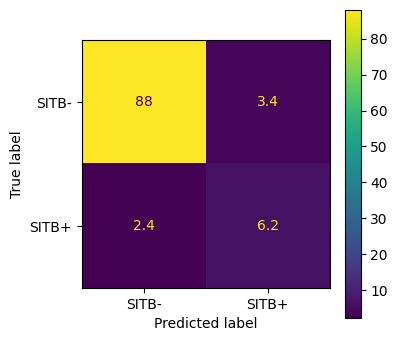

In [62]:
results = {}

clf_report_sklearn = metrics.classification_report(y_test,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
cm_df_meaning, cm_df, cm_df_norm = metrics_report_cm(y_test, y_pred, output_dir_results, model_name, ts, save=True)
clf_report = metrics_report_classification_report(y_test,y_pred,y_pred_proba_1, output_dir_results, model_name, ts)
# scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate
results[model_name] = {
    'clf_report': clf_report,
    'cm_df_meaning': cm_df_meaning,
    'cm_df': cm_df,
    'cm_df_norm': cm_df_norm,
    'clf_report_sklearn': clf_report_sklearn

}


In [63]:
for k, v in results.get(model_name).items():
    print(k)
    if k != 'clf_report_sklearn':
      display(v)
    else:
      print(v)
    print()

clf_report


,Sensitivity,Specificity,Precision,F1,ROC AUC,PR AUC,Best th PR AUC
0,0.73,0.96,0.65,0.69,0.85,0.69,1.05



cm_df_meaning


,SITB-,SITB+
SITB-,TN,FP
SITB+,FN,TP



cm_df


,SITB-,SITB+
SITB-,1126,43
SITB+,30,80



cm_df_norm


,SITB-,SITB+
SITB-,88.04,3.36
SITB+,2.35,6.25



clf_report_sklearn
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1169
           1       0.65      0.73      0.69       110

    accuracy                           0.94      1279
   macro avg       0.81      0.85      0.83      1279
weighted avg       0.95      0.94      0.94      1279




In [ ]:
# trainer.evaluate(eval_dataset=encoded_dataset["test"])
# trainer.evaluate() # this is done on the validation set specificed in the Trainer()

In [ ]:
# load model:
#  - https://discuss.huggingface.co/t/how-to-save-my-model-to-use-it-later/20568/6
# - model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# - then just load the trainer, but instead of training you just predict (here I'm training to fine tune, but if we load the fine tuned model , there's no need)


